# Introduction

The goal of this notebooks is to explore a given dataset of users who have installed our mobile app and their associated features and predict if a user will listen to podcasts.

In [34]:
# Libraries
# Standard libraries
import pandas as pd
import numpy as np

# Statistics and modelings libraries
import sklearn

# Data Viz
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

In [5]:
# Inputs

path_to_data = '/Users/juliameo/dataIntelligence_exercise/part2_ML/data/ds_practical.txt'

## Reading in Data and Prepping

In [8]:
raw_df = pd.read_csv(path_to_data,
                    sep='|')

In [15]:
raw_df.head()

,anon_person_id,target,state,presence_of_child_ind,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,income,number_of_news_subs,age
0,1,0,CA,0,N,0,M,Female,$175k-199k,0,43.0
1,2,0,CA,0,N,0,U,Male,$225k-249k,0,90.0
2,3,1,CA,0,Y,1,S,Female,$150k-174k,0,46.0
3,4,0,CA,1,N,0,U,Female,$125k-149k,0,25.0
4,5,0,CA,0,N,0,U,Female,$175k-199k,0,62.0


In [16]:
raw_df.shape

(1000000, 11)

In [20]:
# Dropping exact duplicates
raw_df.drop_duplicates(inplace=True)

In [21]:
raw_df.shape

(999500, 11)

In [22]:
raw_df.anon_person_id.nunique()

999500

In [26]:
# Looking at count of nulls per column
raw_df.isnull().sum(axis=0)

anon_person_id                      0
target                              0
state                           10024
presence_of_child_ind               0
streaming_media_subs                0
streaming_entertainment_subs        0
marital_status                      0
gender                              0
income                              0
number_of_news_subs                 0
age                             19601
dtype: int64

In [31]:
# Converting the streaming_media_subs field to actual boolean
raw_df['streaming_media_subs'] = np.where(raw_df['streaming_media_subs']=='Y',1,0)

In [58]:
# Changning the boolean fields to object type
raw_df['presence_of_child_ind'] = raw_df['presence_of_child_ind'].astype(str)
raw_df['streaming_media_subs'] = raw_df['streaming_media_subs'].astype(str)
raw_df['streaming_entertainment_subs'] = raw_df['streaming_entertainment_subs'].astype(str)

In [59]:
raw_df.dtypes

anon_person_id                    int64
target                            int64
state                            object
presence_of_child_ind            object
streaming_media_subs             object
streaming_entertainment_subs     object
marital_status                   object
gender                           object
income                           object
number_of_news_subs               int64
age                             float64
dtype: object

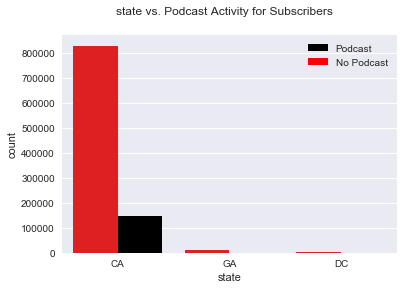

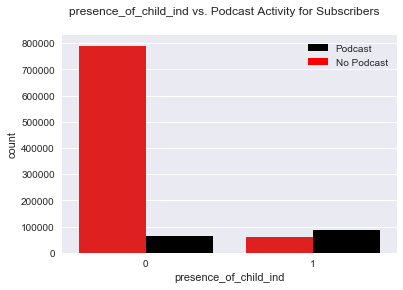

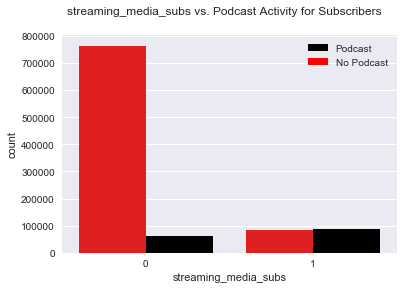

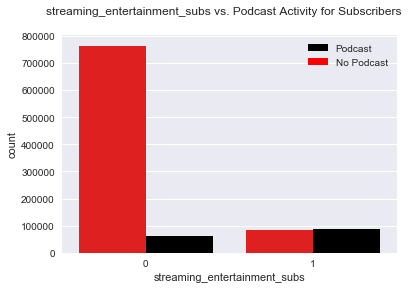

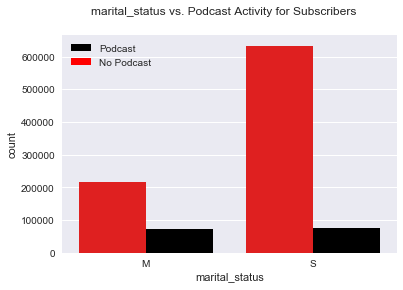

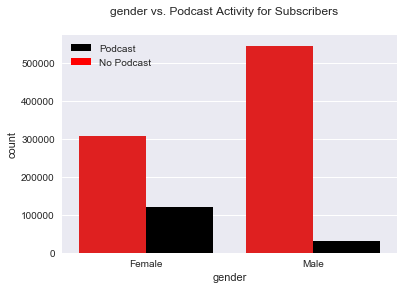

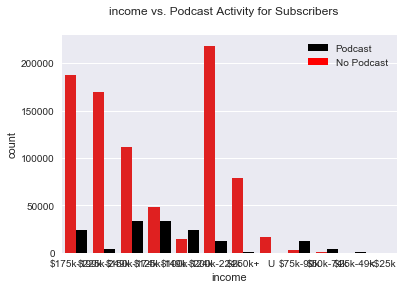

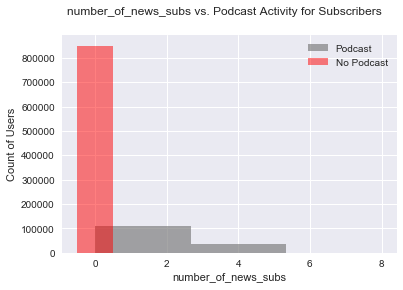

ValueError: max must be larger than min in range parameter.

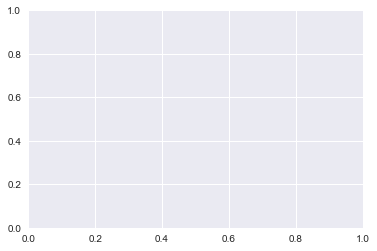

In [97]:
for col in (raw_df.drop(['anon_person_id','target'],axis=1)).columns:
    if raw_df[col].dtype == 'object':
        # Plotting for categorical variables
        fig, ax = plt.subplots()

        sns.factorplot(col, hue="target", data=raw_df, kind="count", 
                    palette={1:"black", 0:"red"}, ax=ax)
        ax.set_xlabel(col)

        color_patches = [
            Patch(facecolor="black", label="Podcast"),
            Patch(facecolor="red", label="No Podcast")
        ]
        ax.legend(handles=color_patches)

        fig.suptitle(col + " vs. Podcast Activity for Subscribers")
        plt.close(2)
        plt.show()
    else:
        fig, ax = plt.subplots()

        ax.hist(raw_df[raw_df["target"]==1][col],
                bins=3, 
                alpha=0.7, 
                color="gray", 
                label="Podcast")
        ax.hist(raw_df[raw_df["target"]==0][col],
                bins=1,
                alpha=0.5,
                color="red",
                label="No Podcast")

        ax.set_xlabel(col)
        ax.set_ylabel("Count of Users")

        fig.suptitle(col + " vs. Podcast Activity for Subscribers")

        ax.legend()
        plt.close(2)
        plt.show()

### High Level Summary of the Data
- 1M records with 999500 unique records for 999500 unique users.
- Most fields have full coverage, but the user age and user state are missing values (~2% and ~1% respectively)
- 3 Unique Values for States: California, Georgia, and Washington, DC
- Assuming the "U" and "S" values for the Marital Status field both indicate unmarried status

In [68]:
# Cleaning up marital status field, assigning 'U' value to 'S'
raw_df['marital_status'] = np.where(raw_df['marital_status']=='U',
                                    'S',
                                    raw_df['marital_status'] )

In [71]:
# Cleaning up gender field, assigning 'feMalee' value to 'Female'
raw_df['gender'] = np.where(raw_df['gender']=='feMalee',
                                    'Female',
                                    raw_df['gender'] )

In [76]:
raw_df.head()

,anon_person_id,target,state,presence_of_child_ind,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,income,number_of_news_subs,age
0,1,0,CA,0,0,0,M,Female,$175k-199k,0,43.0
1,2,0,CA,0,0,0,S,Male,$225k-249k,0,90.0
2,3,1,CA,0,1,1,S,Female,$150k-174k,0,46.0
3,4,0,CA,1,0,0,S,Female,$125k-149k,0,25.0
4,5,0,CA,0,0,0,S,Female,$175k-199k,0,62.0


-----
We want to prepare the non-binary categorial features (State, marital_status, gender and income) for measuring correlation with respect to the target variable.

In [89]:
# One-hot encoding state
prep_df = raw_df.copy()
for col  in ['state','marital_status','gender','income']:
    print("Getting dummies for " +col)
    dummies = pd.get_dummies(prep_df[col], prefix=col)
    prep_df = prep_df.join(dummies)

# Dropping the columns we no longer need
prep_df.drop(['state','marital_status','gender','income'],axis=1, inplace=True)

Getting dummies for state
Getting dummies for marital_status
Getting dummies for gender
Getting dummies for income


In [84]:
# One-hot encoding marital status
ms_dummies = pd.get_dummies(prep_df.marital_status, prefix='state')
prep_df = prep_df.join(ms_dummies)

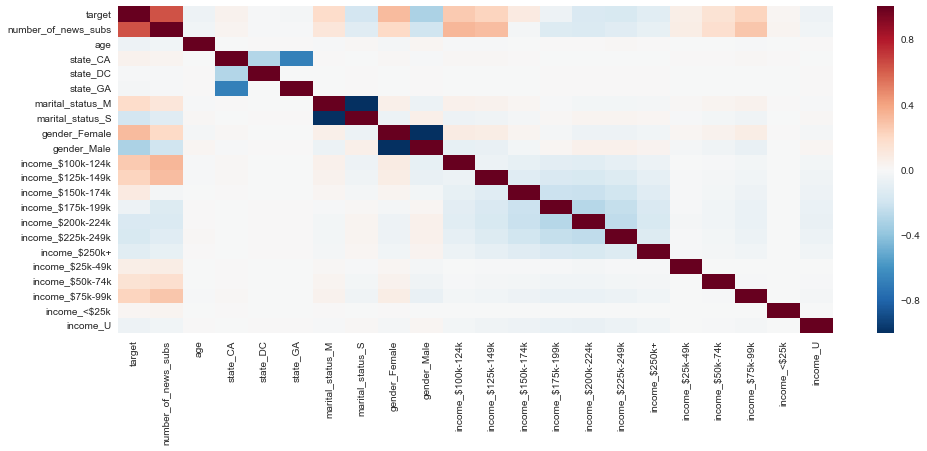

In [96]:
# looking at the correlation of variables.
# What I'm looking for here is first, which variables have correlation with the target variables
# and second, if any of the variables are strongly correlated with each other, making using both
# variables redundant.
plt.figure(figsize=(16, 6))
sns.heatmap((prep_df.drop(['anon_person_id'],axis=1)).corr())

### Correlation Summary
- The number of news subscriptions demonstrates the strongest correlation with the target
- Gender and several of the income "buckets" also demonstrate some correlation with the target
- State and Age seem to have very little or no correlation with the target

----
# Training the Model
I will explore a logistic regression approach, using recurvise feature elimination to select the features for the model.

Model Evaluation Metrics will include
- Accuracy: Count of incorrect predictions/Count of Correct Predictions
- Precision: tp / (tp + fp)
- Recall: tp / (tp + fn) 
- F-Score: A weighted mean of the precision and recall

In [104]:
# First we have to split the data
prep_df.set_index('anon_person_id',inplace=True)

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [109]:
prep_df.dropna(inplace=True)

In [127]:
# Trying to find which features are actually important wrt target
# We look at different combinations of features, train a logit and then select the 
# set of features for the best performing model. note the "best model" here is just
# exploratory
fvars=prep_df.columns.values.tolist()
y=['target']
X=[i for i in fvars if i not in y]
# Instiating the model
logreg = LogisticRegression()
rfe = RFE(logreg,
          10 # This specifies to select 12 features, roughly half of the total features available
         )
rfe = rfe.fit(prep_df[X], prep_df[y].values.ravel())
# Printing out which fields seem 
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False False False False False False False  True
  True  True  True  True False False False False False  True False False]
[ 1  1  1  1 14  5 13  7  4  3  9  1  1  1  1  1  2  6 12 11  8  1 15 10]


In [161]:
good_feats = ['presence_of_child_ind',
             'streaming_media_subs',
             'streaming_entertainment_subs',
             'number_of_news_subs',
#              'marital_status_S',
             'gender_Male',
             'income_$100k-124k',
             'income_$125k-149k',
             'income_$150k-174k',
             'income_$175k-199k',
             'income_$75k-99k',
              ]
good_feats_X= prep_df[good_feats].copy()

In [162]:
good_feats_X['presence_of_child_ind'] = good_feats_X['presence_of_child_ind'].astype(int)
good_feats_X['streaming_media_subs'] = good_feats_X['streaming_media_subs'].astype(int)
good_feats_X['streaming_entertainment_subs'] = good_feats_X['streaming_entertainment_subs'].astype(int)

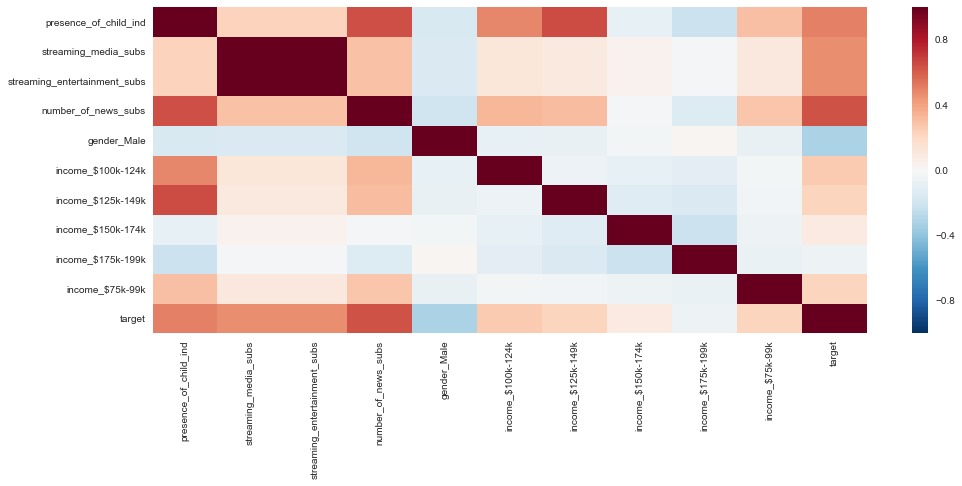

In [163]:
# Looking at the correlation again to see if these features are all actually siginificant wrt to the target
plt.figure(figsize=(16, 6))
sns.heatmap((good_feats_X.join(prep_df[y])).corr())

In [164]:
# Splitting up the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(good_feats_X
                                                    , prep_df[y]
                                                    , test_size=0.3
                                                    , random_state=0)
# Training the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [165]:
# Getting predictions for the test set
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


In [189]:
# Getting the probability of memebership to target=1 class or target=0 class
X_test_probs = logreg.predict_proba(X_test)

In [166]:
# Getting the confusion matrix to see our breakdown of tps, fps, tns, and fns
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[246439   3478]
 [ 13425  30628]]


In [173]:
from sklearn.metrics import classification_report
# Leveraging sklearn's built in model metrics
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97    249917
          1       0.90      0.70      0.78     44053

avg / total       0.94      0.94      0.94    293970



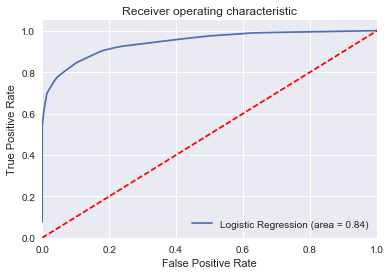

In [174]:
# looking at the ROC curve for good measure
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Hooray! Looks decent, certainly better than random :-)

In [192]:
logreg.classes_

array([0, 1])

In [193]:
X_test_probs_1 = [x[1] for x in X_test_probs]

In [195]:
# Prepping the final files
final_preds_test = pd.DataFrame({'anon_person_id':X_test.index,
              'target':y_test.target,
              'prediction':y_pred,
              'probability':X_test_probs_1
             })

In [197]:
final_preds_test = final_preds_test[['anon_person_id','target','prediction','probability']].copy()

In [201]:
final_preds_test

,anon_person_id,target,prediction,probability
anon_person_id,,,,
524981,524981,0,0,0.034306
691694,691694,0,0,0.172769
794924,794924,0,0,0.004940
509087,509087,0,0,0.115471
414348,414348,1,1,0.629249
458931,458931,0,0,0.115471
348321,348321,0,0,0.004940
685481,685481,0,0,0.028359
987263,987263,0,0,0.115471


In [205]:
# Writing to file
final_preds_test.to_csv('../data/Scores.csv',header=None,index=False)